# RESNET50 model for Plant Classification and Disease Detection​

​

First, we trained the tomato REsNet50 model with resnetweights but insted of freeezing we unfreezed 4 layers, so that weights of the ResNet50 model gets mixed or updated with some features of the tomato features. Now we saved this model which has updated weights, And we used this model for the training mango dataset. By this way i'm just creating a weights, which is the combination of original ResNet50 features and tomato,mango,rice leaves. And then finally training A similar model architecture with the weights gained after training "Rice Dataset" on a combined dataset of rice, mango, tomato. We went throught all this trouble for finding a good balanced number of layer to unfreez for each dataset. So the we can avoide Bias. Because the dataset is not in equal proportions its like rice:mango:Tomato=10:35:55. 

Initially we tried with unfreezing same no of few layes for each model, the prediction was always tomato or mango its not recognising the rice. So we tried to unfreeze no of layers for rice only it didnt worlk out well, so we played with th no of layers and data too. Finally we increased the no of layers to unfreez exponentially with the model.

We also tried to use a custom ResNet9 model, but it was a bit too much because its taking for ever to run 1 epoch like 7 to 8 hours we thought maybe we are at faulty with the architectuire.we used a Initial Convolutional Block (conv1) which Applies initial convolution to input images,Second Convolutional Block (conv2) which Further processes features includes pooling if pool=True, First Residual Block (res1), where Two convolutional layers with a shortcut connection adding input to output, Third Convolutional Block (conv3) this Continues with feature processing and reduction and pools if pool=True, Fourth Convolutional Block (conv4) further refines features and includes pooling if pool=True, Second Residual Block (res2) which is similar to res1 with shortcut connection, And the Classifier Block: where
MaxPooling layer: Reducing feature map dimensions.
Flatten layer:  2D to 1D vector.
Dense layer: Outputs classification results based on number of diseases (num_diseases). 


So, we continued with ResNet50.

Tomato ResNe50t Beginning

In [32]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [36]:

train_path = '/Users/hanmarruiu.edu/Desktop/dls project /tomato/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
test_path = '/Users/hanmarruiu.edu/Desktop/dls project /tomato/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

#class labels
class_labels = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold',
                'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
                'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

#images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_path,  
        target_size=(224, 224),  
        batch_size=32,
        class_mode='categorical')  

#images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')



Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [38]:
# ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreezing some of the top layers of the model
for layer in base_model.layers[-4:]:
    layer.trainable = True

#custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # 10 classes for the combined dataset

#model
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [39]:
# Training the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // 32,  
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // 32,
      verbose=1)



Epoch 1/5
573/573 [==============================] - 2888s 5s/step - loss: 0.4856 - accuracy: 0.8422 - val_loss: 3.6975 - val_accuracy: 0.1012
Epoch 2/5
573/573 [==============================] - 2889s 5s/step - loss: 0.1952 - accuracy: 0.9369 - val_loss: 2.4959 - val_accuracy: 0.5900
Epoch 3/5
573/573 [==============================] - 2792s 5s/step - loss: 0.1455 - accuracy: 0.9505 - val_loss: 2.1934 - val_accuracy: 0.6018
Epoch 4/5
573/573 [==============================] - 2775s 5s/step - loss: 0.1235 - accuracy: 0.9598 - val_loss: 0.7370 - val_accuracy: 0.8687
Epoch 5/5
573/573 [==============================] - 2829s 5s/step - loss: 0.1007 - accuracy: 0.9652 - val_loss: 1.4724 - val_accuracy: 0.7681


In [40]:

# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')


144/144 [==============================] - 151s 1s/step - loss: 1.4706 - accuracy: 0.7682
Test Loss: 1.4706, Test Accuracy: 76.82%


In [41]:

save_dir = '/Users/hanmarruiu.edu/Desktop/dls project'

model_file_name = 'tomato_resnet_model.h5'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(os.path.join(save_dir, model_file_name))

print(f"Model saved to {os.path.join(save_dir, model_file_name)}")


Model saved to /Users/hanmarruiu.edu/Desktop/dls project/tomato_resnet_model.h5


loading the above model to the next model.

Mango ResNet50 Model

In [42]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Loading the previously saved tomato model
tomato_model_path = '/Users/hanmarruiu.edu/Desktop/dls project/tomato_resnet_model.h5'
# Loading the previously saved tomato model
model = load_model(tomato_model_path)

# Unfreezing some of the top layers of the model
for layer in model.layers[-17:]:  # Unfreezing the last 30 layers
    layer.trainable = True

# Getting the output of the last convolutional layer
x = model.get_layer('conv5_block3_out').output

#new trainable layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)  # 8 classes for mango dataset

# new model with modified layers
modified_model = Model(inputs=model.input, outputs=predictions)

# Compiling the new model
modified_model.compile(optimizer=Adam(lr=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [43]:

data_dirt = '/Users/hanmarruiu.edu/Desktop/dls project /archive (1)'#mango dataset

labels_dict = {"Anthracnose": 0,
               "Bacterial Canker": 1,
               "Cutting Weevil": 2,
               "Die Back": 3, 
               "Gall Midge": 4,
               "Healthy": 5,
               "Powdery Mildew": 6,
               "Sooty Mould": 7}

images, labels = [], []

# Looping through subdirectories and images
for class_name in labels_dict.keys():
    class_dir = os.path.join(data_dirt, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = Image.open(image_path) 
        image = image.resize((224, 224))  
        img_array = np.array(image)  
        images.append(img_array)
        labels.append(labels_dict[class_name])

#lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Splitting the data into training and testing sets
train_images_1, test_images_1, train_labels_1, test_labels_1 = train_test_split(images, labels, random_state=0)

# Data Augmentations
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

# data augmentation to the training images
train_images_augmented = augment_datagen.flow(train_images_1, train_labels_1, batch_size=32)


# Normalizing the pixel values to [0, 1]
train_images_1 = train_images_1 / 255.0
test_images_1 = test_images_1 / 255.0

print(train_images_1.shape, test_images_1.shape)


(3000, 224, 224, 3) (1000, 224, 224, 3)


In [44]:

# Training with augmented data
history = modified_model.fit(
    train_images_augmented,
    epochs=5,
    validation_data=(test_images_1, test_labels_1)
)




Epoch 1/5
94/94 [==============================] - 499s 5s/step - loss: 0.3071 - accuracy: 0.9113 - val_loss: 40.6736 - val_accuracy: 0.2300
Epoch 2/5
94/94 [==============================] - 486s 5s/step - loss: 0.1092 - accuracy: 0.9677 - val_loss: 0.6097 - val_accuracy: 0.9040
Epoch 3/5
94/94 [==============================] - 485s 5s/step - loss: 0.0629 - accuracy: 0.9783 - val_loss: 0.9545 - val_accuracy: 0.7320
Epoch 4/5
94/94 [==============================] - 488s 5s/step - loss: 0.0488 - accuracy: 0.9890 - val_loss: 338.8796 - val_accuracy: 0.1300
Epoch 5/5
94/94 [==============================] - 478s 5s/step - loss: 0.1297 - accuracy: 0.9620 - val_loss: 6.2840 - val_accuracy: 0.3840


In [45]:
# Evaluating on the test data
test_loss, test_accuracy = modified_model.evaluate(test_images_1, test_labels_1)
print("Test accuracy:", test_accuracy)


32/32 [==============================] - 33s 1s/step - loss: 6.2840 - accuracy: 0.3840
Test accuracy: 0.3840000033378601


In [46]:

save_dir = '/Users/hanmarruiu.edu/Desktop/dls project'

model_file_name = 'combined_resnet_model_mango_tomato.h5'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_save_path = os.path.join(save_dir, model_file_name)
modified_model.save(model_save_path)

print(f"Model saved to {model_save_path}")


/Users/hanmarruiu.edu/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /Users/hanmarruiu.edu/Desktop/dls project/combined_resnet_model_mango_tomato.h5


loading the above model to the next model.

rice ResNet50 model

In [47]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

combined_model_path = '/Users/hanmarruiu.edu/Desktop/dls project/combined_resnet_model_mango_tomato.h5'
model = load_model(combined_model_path)

# Unfreezingh the last 10 layers of the model
for layer in model.layers[-30:]:
    layer.trainable = True

# output of the last convolutional layer
x = model.get_layer('conv5_block3_out').output

#new trainable layers for the rice dataset
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes for rice dataset

# model with modified layers
modified_model = Model(inputs=model.input, outputs=predictions)

# Compiling the new model
modified_model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data preparation and augmentation for rice dataset
data_dir = '/Users/hanmarruiu.edu/Desktop/dls project /rice'
labels_dict = {"Bacterial leaf blight": 0, "Brown spot": 1, "Leaf smut": 2}

images, labels = [], []
for class_name in labels_dict.keys():
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        img_array = np.array(image)
        images.append(img_array)
        labels.append(labels_dict[class_name])

images = np.array(images)
labels = np.array(labels)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.25, random_state=0)

# Data Augmentationstep
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

train_images_augmented = augment_datagen.flow(train_images, train_labels, batch_size=32)

# Normalizin g the pixel values of test images
test_images = test_images / 255.0

# Training with augmented data
history = modified_model.fit(
    train_images_augmented,
    epochs=30,
    validation_data=(test_images, test_labels)
)


Epoch 1/30
3/3 [==============================] - 17s 6s/step - loss: 1.0154 - accuracy: 0.5222 - val_loss: 0.9686 - val_accuracy: 0.4667
Epoch 2/30
3/3 [==============================] - 15s 5s/step - loss: 0.4118 - accuracy: 0.8889 - val_loss: 1.5797 - val_accuracy: 0.4333
Epoch 3/30
3/3 [==============================] - 15s 5s/step - loss: 0.2451 - accuracy: 0.9111 - val_loss: 1.8731 - val_accuracy: 0.4667
Epoch 4/30
3/3 [==============================] - 14s 5s/step - loss: 0.1240 - accuracy: 0.9556 - val_loss: 2.0920 - val_accuracy: 0.3667
Epoch 5/30
3/3 [==============================] - 14s 5s/step - loss: 0.0885 - accuracy: 0.9556 - val_loss: 2.2785 - val_accuracy: 0.4333
Epoch 6/30
3/3 [==============================] - 14s 5s/step - loss: 0.0525 - accuracy: 0.9889 - val_loss: 2.3263 - val_accuracy: 0.4667
Epoch 7/30
3/3 [==============================] - 14s 5s/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 2.2307 - val_accuracy: 0.5667
Epoch 8/30
3/3 [==================

In [48]:

# Evaluating on the test data
test_loss, test_accuracy = modified_model.evaluate(test_images, test_labels)
print("Test accuracy:", test_accuracy)


1/1 [==============================] - 1s 1s/step - loss: 6.9377 - accuracy: 0.4667
Test accuracy: 0.46666666865348816


In [49]:

save_dir = '/Users/hanmarruiu.edu/Desktop/dls project'

model_file_name = 'final_trained_model.h5'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_save_path = os.path.join(save_dir, model_file_name)
modified_model.save(model_save_path)

print(f"Trained model saved to {model_save_path}")


Trained model saved to /Users/hanmarruiu.edu/Desktop/dls project/final_trained_model.h5


In [50]:

weights_dir = '/Users/hanmarruiu.edu/Desktop/dls project'

weights_file_name = 'final_trained_weights.h5'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)
weights_save_path = os.path.join(weights_dir, weights_file_name)
modified_model.save_weights(weights_save_path)

print(f"Weights saved to {weights_save_path}")


Weights saved to /Users/hanmarruiu.edu/Desktop/dls project/final_trained_weights.h5


Final Model below which is the end of the bottle-neck apporach with weights and model

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#the dataset path and the number of classes
dataset_path = '/Users/hanmarruiu.edu/Desktop/dls project /Combined_dataset'
num_classes = 21


# ImageDataGenerator with a validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

# the target image size and batch size
target_size = (224, 224)
batch_size = 128

# Loading images 
train_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  
    shuffle=True
)

validation_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation', 
    shuffle=False
)

# Displaying the class labels and the shape of the datasets
class_labels = train_dataset.class_indices
print("Class Labels:", class_labels)
print("Train Dataset Shape:", train_dataset.samples, "images,", len(class_labels), "classes")
print("Validation Dataset Shape:", validation_dataset.samples, "images,", len(class_labels), "classes")
# Loading the ResNet50 model without weights
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Loading the previously saved weights from last model above
weights_path = '/Users/hanmarruiu.edu/Desktop/dls project/final_trained_weights.h5'
base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)

#custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

#  the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
train_steps_per_epoch = train_dataset.samples // batch_size
validation_steps_per_epoch = validation_dataset.samples // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=5,
    validation_data=validation_dataset,
    validation_steps=validation_steps_per_epoch
)



Found 17974 images belonging to 21 classes.
Found 4491 images belonging to 21 classes.
Class Labels: {'Mango  Gall Midge': 0, 'Mango Anthracnose': 1, 'Mango Bacterial Canker': 2, 'Mango Cutting Weevil': 3, 'Mango Die Back': 4, 'Mango Healthy': 5, 'Mango Powdery Mildew': 6, 'Mango Sooty Mould': 7, 'Rice Bacterial leaf blight': 8, 'Rice Brown spot': 9, 'Rice Leaf smut': 10, 'Tomato___Bacterial_spot': 11, 'Tomato___Early_blight': 12, 'Tomato___Late_blight': 13, 'Tomato___Leaf_Mold': 14, 'Tomato___Septoria_leaf_spot': 15, 'Tomato___Spider_mites Two-spotted_spider_mite': 16, 'Tomato___Target_Spot': 17, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 18, 'Tomato___Tomato_mosaic_virus': 19, 'Tomato___healthy': 20}
Train Dataset Shape: 17974 images, 21 classes
Validation Dataset Shape: 4491 images, 21 classes


Epoch 1/5
140/140 [==============================] - 3544s 25s/step - loss: 0.3113 - accuracy: 0.9021 - val_loss: 0.6693 - val_accuracy: 0.8172
Epoch 2/5
140/140 [==============================] - 3405s 24s/step - loss: 0.0895 - accuracy: 0.9713 - val_loss: 0.2946 - val_accuracy: 0.9123
Epoch 3/5
140/140 [==============================] - 3407s 24s/step - loss: 0.0569 - accuracy: 0.9818 - val_loss: 2.4777 - val_accuracy: 0.7225
Epoch 4/5
140/140 [==============================] - 3413s 24s/step - loss: 0.0512 - accuracy: 0.9829 - val_loss: 0.8776 - val_accuracy: 0.7888
Epoch 5/5
140/140 [==============================] - 3392s 24s/step - loss: 0.0434 - accuracy: 0.9853 - val_loss: 0.2676 - val_accuracy: 0.9257


In [6]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(validation_dataset)
print(f"Test accuracy: {test_accuracy:.2%}")


36/36 [==============================] - 144s 4s/step - loss: 0.2649 - accuracy: 0.9279
Test accuracy: 92.79%


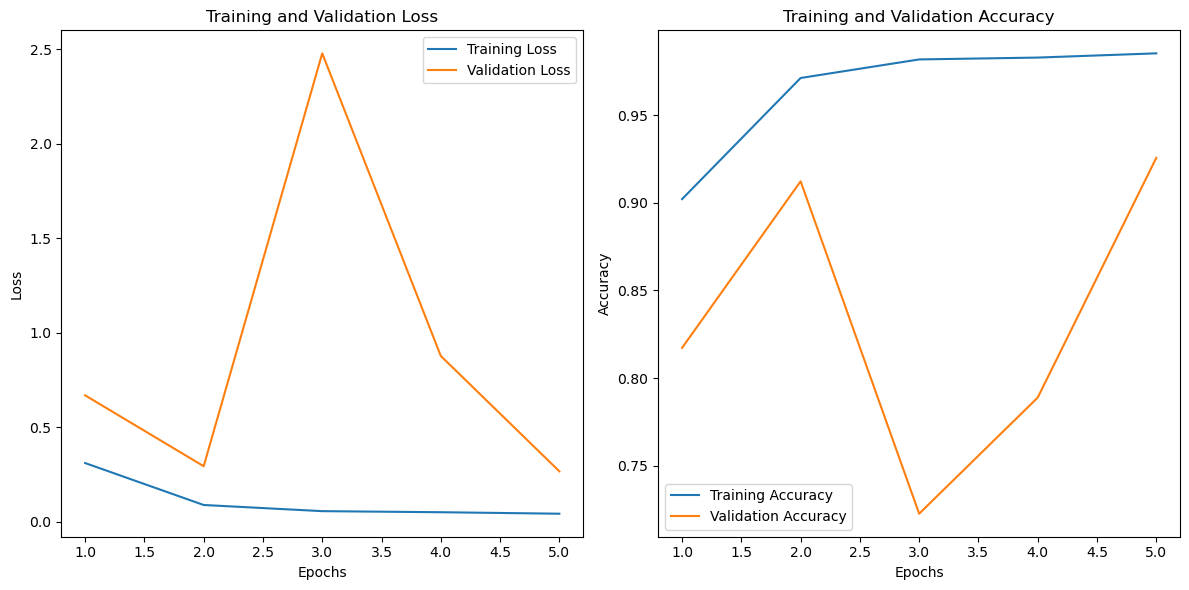

In [14]:
import matplotlib.pyplot as plt

# Extracting the history from the training run
history_dict = history.history

# the metrics used 
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

#the range for x-axis (number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:

model_save_path = '/Users/hanmarruiu.edu/Desktop/dls project/resnet50_trained_model.h5'

model.save(model_save_path)

print(f"Model saved to {model_save_path}")


/Users/hanmarruiu.edu/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /Users/hanmarruiu.edu/Desktop/dls project/resnet50_trained_model.h5


prediction with low-resolution and random images.

In [13]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading the previously saved model
saved_model_path = '/Users/hanmarruiu.edu/Desktop/dls project/resnet50_trained_model.h5'
model = load_model(saved_model_path)

# preprocessing the input image
def preprocess_input_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

# class labels from the training dataset
def get_class_labels(dataset_path):
    datagen_tmp = ImageDataGenerator()
    generator_tmp = datagen_tmp.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)
    return {v: k for k, v in generator_tmp.class_indices.items()}

#dataset
dataset_path = '/Users/hanmarruiu.edu/Desktop/dls project /Combined_dataset'

# Retrieving the class labels
class_labels = get_class_labels(dataset_path)

#makeing predictions on an image
def predict_image(model, image_path, class_labels):
    img_array = preprocess_input_image(image_path, target_size=(224, 224))
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    return predicted_class, np.max(predictions)

# path to the image
image_path_to_predict = '/Users/hanmarruiu.edu/Desktop/DSC_0504.jpg'

# Makeing prediction
predicted_class, confidence = predict_image(model, image_path_to_predict, class_labels)

#the prediction
print(f"The image is predicted as: {predicted_class} with confidence {confidence:.2f}")


Found 22465 images belonging to 21 classes.
1/1 [==============================] - 0s 349ms/step
The image is predicted as: Rice Leaf smut with confidence 0.99
